In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Data Preprocessing  
MISSING_COL_THRESHOLD = 0.30
MISSING_ROW_THRESHOLD = 0.30
K_RANGE = range(2, 9)       
TARGET_CUMVAR = 0.90
RANDOM_STATE = 42
df_climate = pd.read_csv("wbcc_bc.csv")
print("RAW DATA")
print("Shape:", df_climate.shape)
df_climate.head()

RAW DATA
Shape: (217, 79)


,iso3c,country,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,AG.LND.EL5M.RU.K2,AG.LND.EL5M.RU.ZS,AG.LND.EL5M.UR.K2,AG.LND.EL5M.UR.ZS,AG.LND.EL5M.ZS,...,SE.PRM.CMPT.ZS,SH.DYN.MORT,SH.MED.CMHW.P3,SH.STA.MALN.ZS,SI.POV.DDAY,SP.POP.GROW,SP.POP.TOTL,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS
0,ABW,Aruba,20.00,11.111111,11.111111,4.278099,2.352464,8.579794,4.717904,7.070368,...,101.180557,NaN,NaN,NaN,NaN,0.428017,106766,0.774631,46654.0,43.697
1,AFG,Afghanistan,379190.00,58.081365,11.798854,NaN,NaN,NaN,NaN,NaN,...,85.625328,60.3,NaN,19.1,NaN,2.303812,38928341,3.354421,10131490.0,26.026
2,AGO,Angola,569524.90,45.682594,3.930376,1516.944458,0.121392,54.130676,0.004332,0.125724,...,46.187149,74.7,NaN,19.0,49.9,3.218530,32866268,4.192962,21962884.0,66.825
3,ALB,Albania,11740.81,42.849672,22.311898,1294.595459,4.562272,84.844978,0.299001,4.861273,...,103.322746,9.7,NaN,1.5,1.3,-0.577942,2837743,0.853866,1762579.0,62.112
4,AND,Andorra,188.30,40.063830,1.765957,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,0.154134,77265,0.076581,67928.0,87.916


In [3]:
#creating ID column
id_col = "country"
if id_col not in df_climate.columns:
    df_climate[id_col] = [f"row_{i}" for i in range(len(df_climate))]

# Moving ID to first column
df_climate = df_climate[[id_col] + [c for c in df_climate.columns if c != id_col]]

# Dropping columns with too many missing values (except ID column)
no_of_columns_with_missing_data = df_climate.isna().mean()
no_of_columns_to_drop = [c for c in df_climate.columns if c != id_col and no_of_columns_with_missing_data[c] > MISSING_COL_THRESHOLD]
df_climate.drop(columns=no_of_columns_to_drop, inplace=True)

# Dropping rows with too many missing values (except ID column)
no_of_rows_with_missing_data = df_climate.drop(columns=[id_col]).isna().mean(axis=1)
no_of_rows_to_drop = no_of_rows_with_missing_data > MISSING_ROW_THRESHOLD
df_climate = df_climate.loc[~no_of_rows_to_drop].reset_index(drop=True)

print("Modified Dataset")
print(f"Dropped columns (> {MISSING_COL_THRESHOLD:.0%} missing): {no_of_columns_to_drop or 'None'}")
print(f"Dropped rows   (> {MISSING_ROW_THRESHOLD:.0%} missing): {no_of_rows_to_drop.sum()}")
print("Shape now:", df_climate.shape)

Modified Dataset
Dropped columns (> 30% missing): ['AG.LND.IRIG.AG.ZS', 'EG.ELC.COAL.ZS', 'EG.ELC.HYRO.ZS', 'EG.ELC.NGAS.ZS', 'EG.ELC.NUCL.ZS', 'EG.ELC.PETR.ZS', 'EG.ELC.RNWX.KH', 'EG.ELC.RNWX.ZS', 'EG.USE.ELEC.KH.PC', 'EN.ATM.HFCG.KT.CE', 'EN.ATM.PFCG.KT.CE', 'EN.ATM.SF6G.KT.CE', 'EN.CLC.DRSK.XQ', 'EN.CLC.GHGR.MT.CE', 'EN.URB.MCTY.TL.ZS', 'IQ.CPA.PUBS.XQ', 'IS.ROD.PAVE.ZS', 'SH.MED.CMHW.P3', 'SH.STA.MALN.ZS']
Dropped rows   (> 30% missing): 29
Shape now: (188, 60)


In [4]:
#Feature matrix
feature_cols = [c for c in df_climate.columns if c != id_col and pd.api.types.is_numeric_dtype(df_climate[c])]
if len(feature_cols) == 0:
    raise ValueError("No numeric feature columns found after filtering.")
TempDataset = df_climate[feature_cols].copy()
ids = df_climate[id_col].astype(str).fillna("Unknown").values

#Impute + scale
imputer = SimpleImputer(strategy="median")
TempDataset_imp = imputer.fit_transform(TempDataset)

scaler = StandardScaler()
TempDataset_scaled = scaler.fit_transform(TempDataset_imp)

#PCA
pca_full = PCA()
TempDataset_pca_full = pca_full.fit_transform(TempDataset_scaled)
expvar = pca_full.explained_variance_ratio_
cumexp = np.cumsum(expvar)
n_for_target = int(np.searchsorted(cumexp, TARGET_CUMVAR) + 1)

print("PCA SUMMARY")
print(f"Components needed for ~{int(TARGET_CUMVAR*100)}% variance:", n_for_target)
print("Top 10 explained variance ratios:", expvar[:10])

PCA SUMMARY
Components needed for ~90% variance: 23
Top 10 explained variance ratios: [0.20921326 0.1430744  0.07583755 0.06343162 0.05090177 0.04261944
 0.0349835  0.03194793 0.02826355 0.02708023]


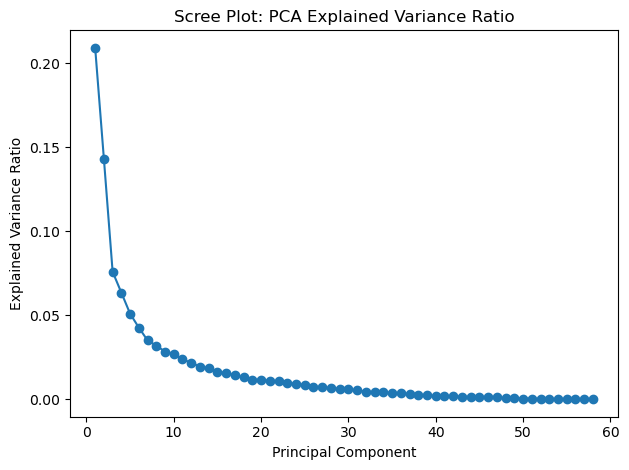

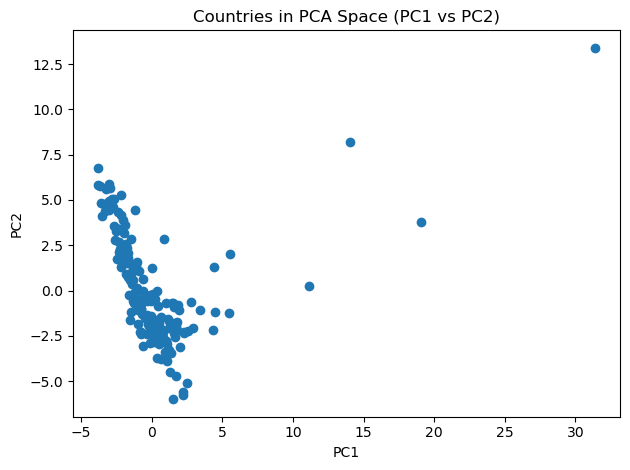

In [5]:
# Scree plot
plt.figure()
plt.plot(np.arange(1, len(expvar) + 1), expvar, marker="o")
plt.title("Scree Plot: PCA Explained Variance Ratio")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.tight_layout()
plt.show()

# 2D PCA for visualisations
pca2 = PCA(n_components=2)
TempDataset_pca2 = pca2.fit_transform(TempDataset_scaled)
df_pca2 = pd.DataFrame({"PC1": TempDataset_pca2[:, 0], "PC2": TempDataset_pca2[:, 1], id_col: ids})

plt.figure()
plt.scatter(df_pca2["PC1"], df_pca2["PC2"])
plt.title("Countries in PCA Space (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

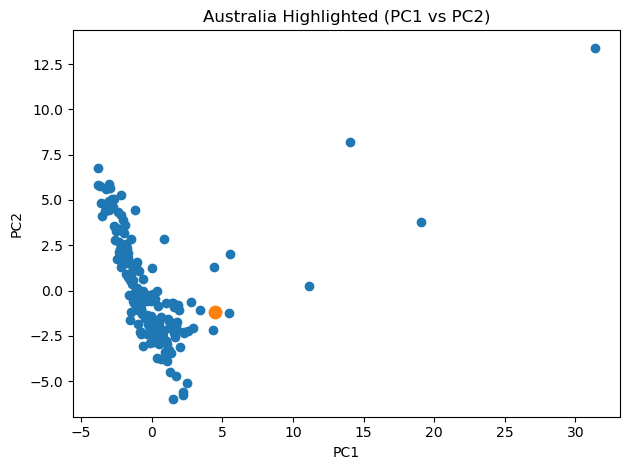

Australia was found and highlighted in PCA space.


In [6]:
# Highlight Australia if it is present
try:
    mask_aus = df_pca2[id_col].str.contains("Australia", case=False, na=False)
    if mask_aus.any():
        au = df_pca2[mask_aus].iloc[0]
        plt.figure()
        plt.scatter(df_pca2["PC1"], df_pca2["PC2"])
        plt.scatter([au["PC1"]], [au["PC2"]], s=80)
        plt.title("Australia Highlighted (PC1 vs PC2)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.tight_layout()
        plt.show()
        print("Australia was found and highlighted in PCA space.")
    else:
        print("Australia not found in ID column.")
except Exception as e:
    print("Australia highlight skipped:", e)

In [7]:
# Data Preprocessing  
MISSING_COL_THRESHOLD = 0.30
MISSING_ROW_THRESHOLD = 0.30
K_RANGE = range(2, 9)       
TARGET_CUMVAR = 0.90
RANDOM_STATE = 42
df_climate = pd.read_csv("wbcc_bc.csv")
print("RAW DATA")
print("Shape:", df_climate.shape)
df_climate.head()

RAW DATA
Shape: (217, 79)


,iso3c,country,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,AG.LND.EL5M.RU.K2,AG.LND.EL5M.RU.ZS,AG.LND.EL5M.UR.K2,AG.LND.EL5M.UR.ZS,AG.LND.EL5M.ZS,...,SE.PRM.CMPT.ZS,SH.DYN.MORT,SH.MED.CMHW.P3,SH.STA.MALN.ZS,SI.POV.DDAY,SP.POP.GROW,SP.POP.TOTL,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS
0,ABW,Aruba,20.00,11.111111,11.111111,4.278099,2.352464,8.579794,4.717904,7.070368,...,101.180557,NaN,NaN,NaN,NaN,0.428017,106766,0.774631,46654.0,43.697
1,AFG,Afghanistan,379190.00,58.081365,11.798854,NaN,NaN,NaN,NaN,NaN,...,85.625328,60.3,NaN,19.1,NaN,2.303812,38928341,3.354421,10131490.0,26.026
2,AGO,Angola,569524.90,45.682594,3.930376,1516.944458,0.121392,54.130676,0.004332,0.125724,...,46.187149,74.7,NaN,19.0,49.9,3.218530,32866268,4.192962,21962884.0,66.825
3,ALB,Albania,11740.81,42.849672,22.311898,1294.595459,4.562272,84.844978,0.299001,4.861273,...,103.322746,9.7,NaN,1.5,1.3,-0.577942,2837743,0.853866,1762579.0,62.112
4,AND,Andorra,188.30,40.063830,1.765957,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,0.154134,77265,0.076581,67928.0,87.916


C:\Users\shaba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shaba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shaba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shaba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

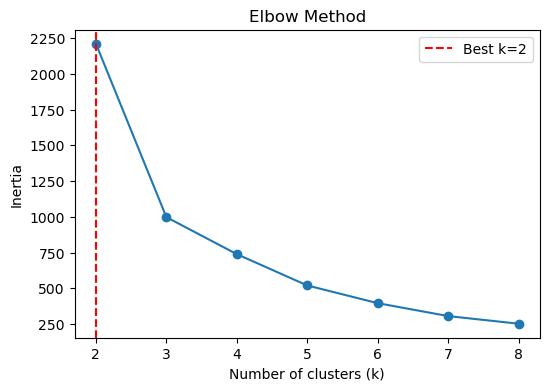

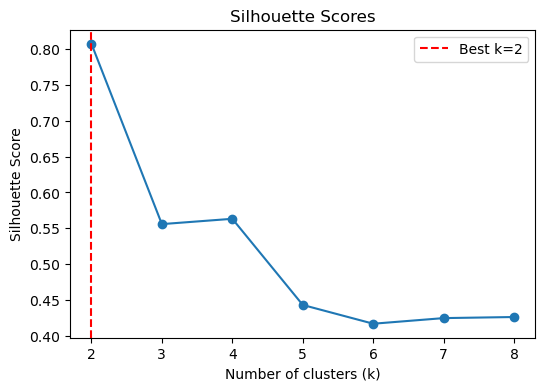

Best k (by silhouette, fallback=3): 2


In [8]:
# fixing MKL memory warning for Windows
os.environ["OMP_NUM_THREADS"] = "1"

# K search (Elbow + Silhouette)
inertias, sils = [], []

for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(TempDataset_pca2)  # cluster on 2D PCA data

    inertias.append(km.inertia_)

    # Compute silhouette if valid
    if len(np.unique(labels)) > 1:
        sils.append(silhouette_score(TempDataset_pca2, labels))
    else:
        sils.append(np.nan)

# Choosing best k
best_k = 3 if all(np.isnan(sils)) else K_RANGE[np.nanargmax(sils)]

# --- Elbow Plot ---
plt.figure(figsize=(6,4))
plt.plot(K_RANGE, inertias, marker='o')
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.legend()
plt.show()

# Silhouette Plot 
plt.figure(figsize=(6,4))
plt.plot(K_RANGE, sils, marker='o')
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.title("Silhouette Scores")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

print(f"Best k (by silhouette, fallback=3): {best_k}")

C:\Users\shaba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


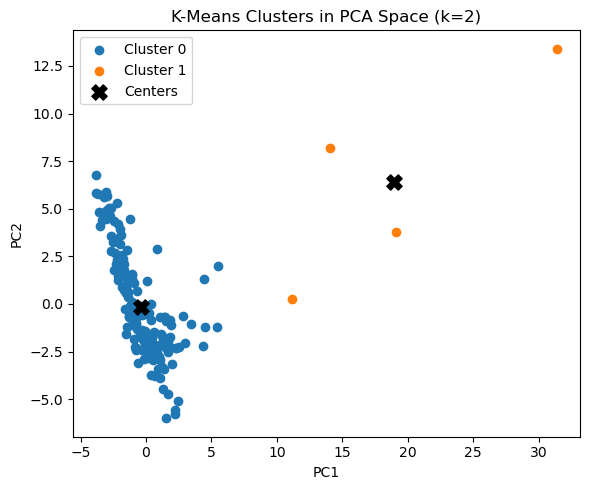

In [9]:
# fixing MKL memory warning for Windows
os.environ["OMP_NUM_THREADS"] = "1"

# Final K-Means + Cluster Plot
kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(TempDataset_pca2)

# Add labels to the PCA dataframe
df_pca2["cluster"] = labels

# Plot clusters in PCA space
plt.figure(figsize=(6,5))
for k in sorted(df_pca2["cluster"].unique()):
    part = df_pca2[df_pca2["cluster"] == k]
    plt.scatter(part["PC1"], part["PC2"], label=f"Cluster {k}")

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=120, marker='X', label='Centers')

plt.title(f"K-Means Clusters in PCA Space (k={best_k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Cluster profiles (original units; on imputed data)
TempDataset_imp_df = pd.DataFrame(TempDataset_imp, columns=feature_cols)
df_clusters = pd.concat([pd.Series(ids, name=id_col),
                         pd.Series(labels, name="cluster"),
                         TempDataset_imp_df], axis=1)

cluster_profile = df_clusters.groupby("cluster")[feature_cols].mean()
# Focus on top 15 varying indicators across clusters
variances = cluster_profile.var().sort_values(ascending=False)
top_feats = list(variances.head(15).index)
cluster_profile_top = cluster_profile[top_feats]

output_csv = "cluster_profile_top.csv"
cluster_profile_top.to_csv(output_csv, index=True)
print(f"Saved cluster profile top 15 varying indicators = {output_csv}")
print("Top-varying indicators:", top_feats)
print("\nCluster profile preview:")
print(cluster_profile_top.head())

Saved cluster profile top 15 varying indicators = cluster_profile_top.csv
Top-varying indicators: ['SP.POP.TOTL', 'SP.URB.TOTL', 'EN.ATM.GHGT.KT.CE', 'EN.ATM.CO2E.KT', 'AG.LND.FRST.K2', 'AG.LND.AGRI.K2', 'EN.ATM.CO2E.SF.KT', 'EN.ATM.CO2E.LF.KT', 'EN.ATM.METH.KT.CE', 'EN.ATM.CO2E.GF.KT', 'EN.ATM.NOXE.KT.CE', 'EN.ATM.GHGO.KT.CE', 'AG.LND.EL5M.RU.K2', 'EN.ATM.GHGO.ZG', 'AG.LND.EL5M.UR.K2']

Cluster profile preview:
          SP.POP.TOTL   SP.URB.TOTL  EN.ATM.GHGT.KT.CE  EN.ATM.CO2E.KT  \
cluster                                                                  
0        2.414160e+07  1.408363e+07       1.169411e+05    7.739234e+04   
1        8.139261e+08  4.308395e+08       6.074312e+06    4.834208e+06   

         AG.LND.FRST.K2  AG.LND.AGRI.K2  EN.ATM.CO2E.SF.KT  EN.ATM.CO2E.LF.KT  \
cluster                                                                         
0          1.426046e+05    1.867252e+05       1.963894e+04       3.185170e+04   
1          3.543112e+06    3.323768e+06     

In [11]:
# Australia Cluster & Profile Comparison
try:
    mask = pd.Series(ids).str.contains("Australia", case=False, na=False)
    if mask.any():
        aus = df_clusters.loc[mask].iloc[0]
        cluster_id = int(aus["cluster"])
        print(f"Australia found at Cluster {cluster_id}")

        # Comparing Australia's values vs cluster mean
        diffs = (aus[feature_cols] - cluster_profile.loc[cluster_id, feature_cols]).sort_values(ascending=False)
        print("\n Top 10 indicators where Australia is ABOVE its cluster mean:")
        print(diffs.head(10).round(3))
        print("\n Top 10 indicators where Australia is BELOW its cluster mean:")
        print(diffs.tail(10).round(3))
    else:
        print("Australia not found in dataset — skipping comparison.")
except Exception as e:
    print("Australia comparison skipped due to error:", e)

Australia found at Cluster 0

 Top 10 indicators where Australia is ABOVE its cluster mean:
SP.URB.TOTL          8069130.396739
AG.LND.AGRI.K2       3402224.807397
SP.POP.TOTL          1545436.608696
AG.LND.FRST.K2       1197446.369565
EN.ATM.GHGT.KT.CE     498438.858696
EN.ATM.CO2E.KT        309227.663043
EN.ATM.CO2E.SF.KT      152959.41863
EN.ATM.METH.KT.CE     113184.782609
EN.ATM.CO2E.LF.KT      87058.107495
EN.ATM.NOXE.KT.CE      66650.923913
dtype: object

 Top 10 indicators where Australia is BELOW its cluster mean:
EN.ATM.GHGT.ZG         -25.942191
EN.ATM.CO2E.LF.ZS      -30.623928
EN.ATM.NOXE.ZG         -37.375428
EN.ATM.METH.ZG         -39.640252
IC.BUS.EASE.XQ         -83.652174
ER.H2O.FWTL.ZS        -113.022277
AG.LND.PRCP.MM        -640.397283
AG.YLD.CREL.KG       -1513.678804
EN.ATM.GHGO.ZG      -12462.140711
EN.ATM.GHGO.KT.CE   -17745.201678
dtype: object
